## Inicialización

In [1]:
import sys
sys.path.append('..')

from megaline import hypotesis_testing as mht

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Markdown, display

## Cargar datos limpios

In [3]:
usage_data = pd.read_parquet('../data/clean/usage_data.parquet')

## Estudia el comportamiento de usuario

In [4]:
grouped = usage_data.groupby(['year_month', 'plan_name']).agg(
    total_payment=('total_payment', 'sum'),
    monthly_plan_fee=('monthly_plan_fee', 'sum'),
    excess_usage=('excess_usage', 'sum'),
    calls_count=('total_minutes', 'size'),
    minutes_sum=('total_minutes', 'sum'),
    sms_count=('total_sms', 'size'),
    gb_used=('total_gb', 'sum')
).reset_index()

In [5]:
print(grouped.head().to_markdown())

|    | year_month   | plan_name   |   total_payment |   monthly_plan_fee |   excess_usage |   calls_count |   minutes_sum |   sms_count |   gb_used |
|---:|:-------------|:------------|----------------:|-------------------:|---------------:|--------------:|--------------:|------------:|----------:|
|  0 | 2018-01      | surf        |          600    |                600 |           0    |            30 |           406 |          30 |        10 |
|  1 | 2018-01      | ultimate    |         1330    |               1330 |           0    |            19 |           774 |          19 |        29 |
|  2 | 2018-02      | surf        |          809.57 |                680 |         129.57 |            34 |          2673 |          34 |       110 |
|  3 | 2018-02      | ultimate    |         1190    |               1190 |           0    |            17 |          2822 |          17 |       121 |
|  4 | 2018-03      | surf        |         1496.65 |                900 |         596.65 |         

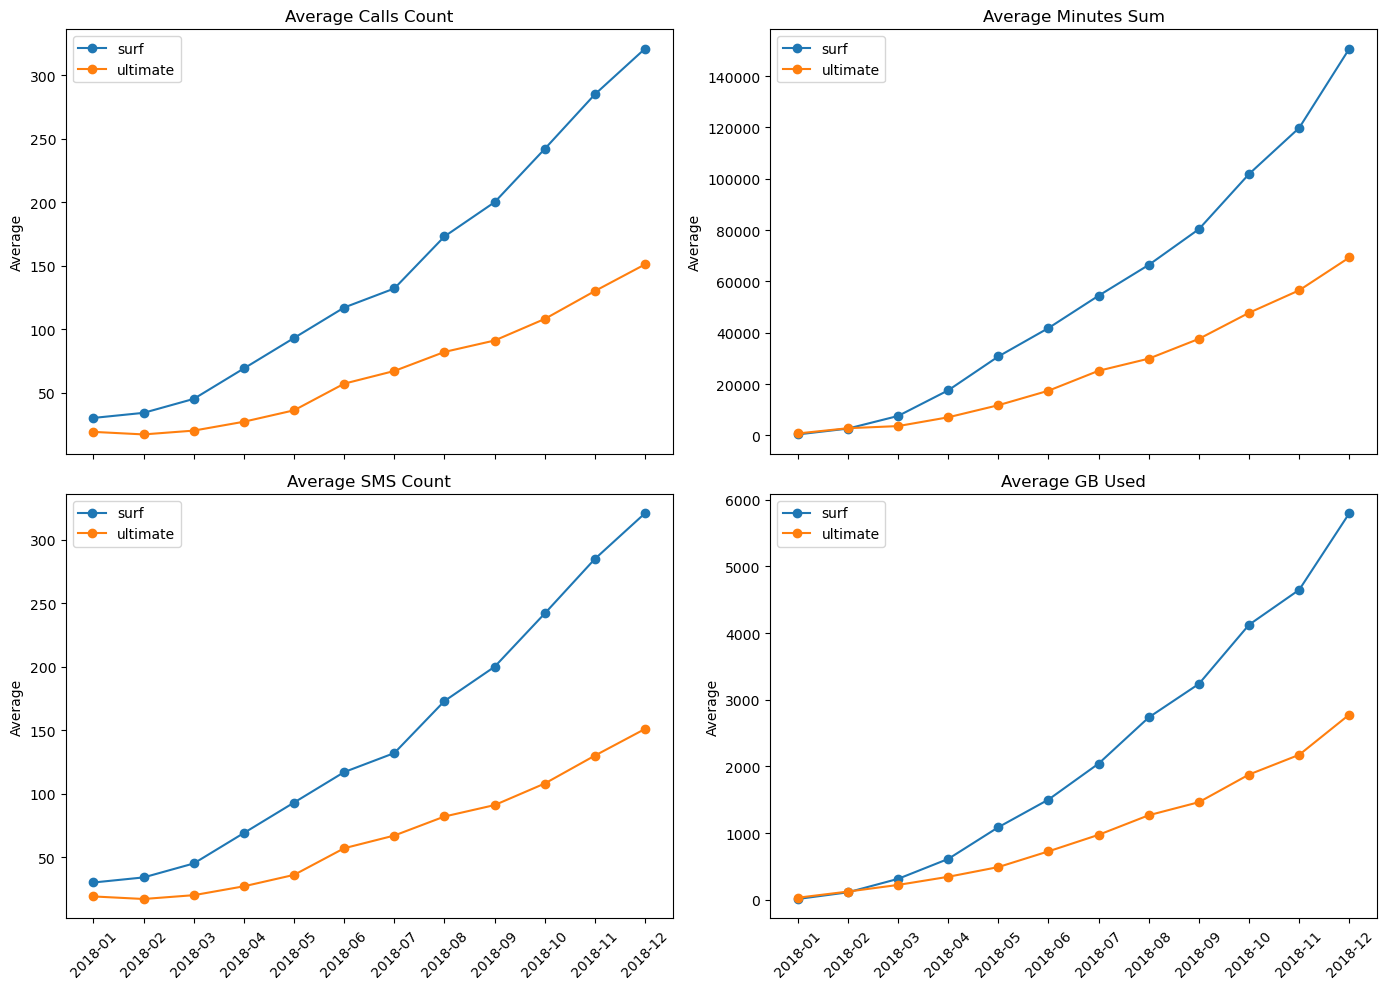

In [6]:
# Crear el gráfico de líneas
fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

metrics = ['calls_count', 'minutes_sum', 'sms_count', 'gb_used']
titles = ['Average Calls Count', 'Average Minutes Sum', 'Average SMS Count', 'Average GB Used']

plans = grouped['plan_name'].unique()
months = grouped['year_month'].unique().astype(str)

index = np.arange(len(months))

for i, metric in enumerate(metrics):
    ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].set_ylabel('Average')
    for plan in plans:
        data = grouped[grouped['plan_name'] == plan][metric].values
        ax[i//2, i%2].plot(months, data, label=plan, marker='o')  # Changed to line plot with markers
    
    ax[i//2, i%2].set_xticks(index)
    ax[i//2, i%2].set_xticklabels(months)
    ax[i//2, i%2].legend()
    # Apply rotation to x-tick labels for each subplot
    for tick in ax[i//2, i%2].get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

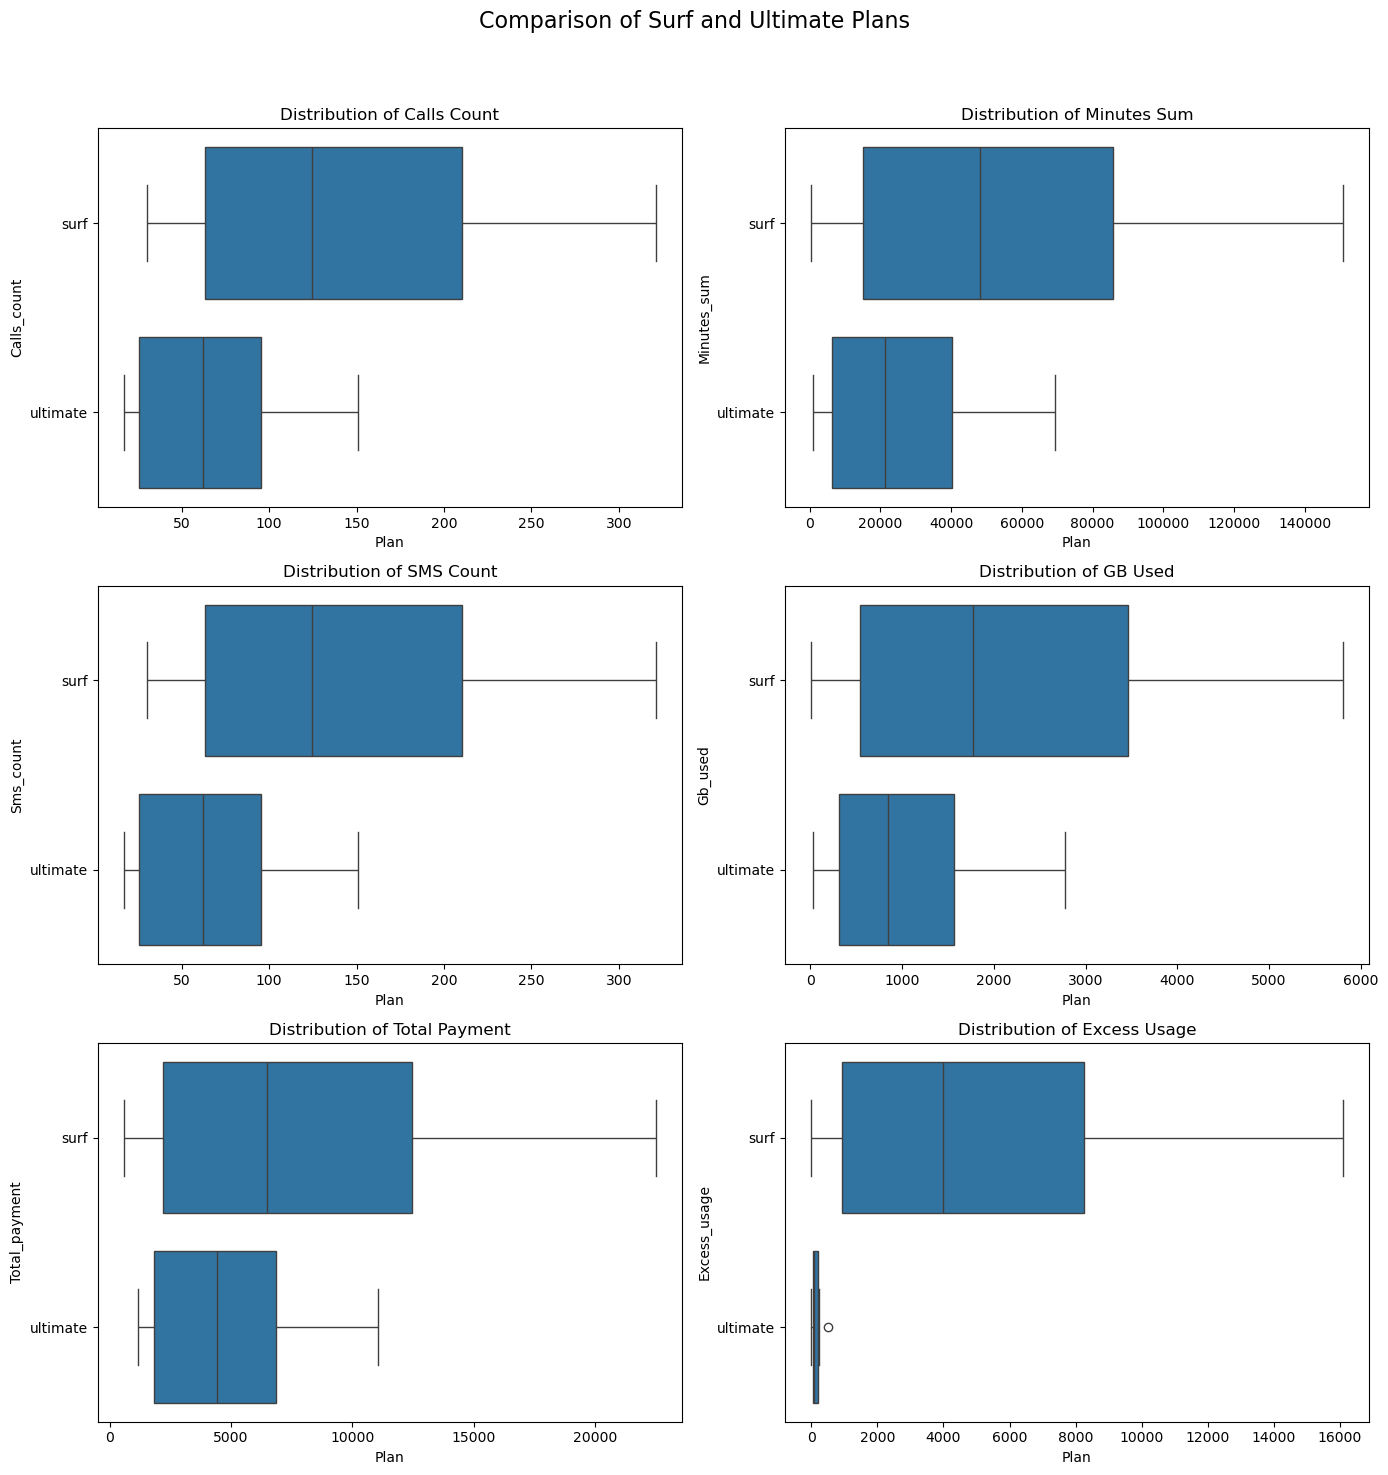

In [7]:
# Agregar columnas para diferentes categorías, incluyendo ingresos y gastos extras
categories = ['calls_count', 'minutes_sum', 'sms_count', 'gb_used', 'total_payment', 'excess_usage']
titles = ['Calls Count', 'Minutes Sum', 'SMS Count', 'GB Used', 'Total Payment', 'Excess Usage']

# Crear el gráfico de cajas y bigotes
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle('Comparison of Surf and Ultimate Plans', fontsize=16)

for i, category in enumerate(categories):
    sns.boxplot(x=category, y='plan_name', data=grouped, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {titles[i]}')
    axes[i//2, i%2].set_ylabel(category.capitalize())
    axes[i//2, i%2].set_xlabel('Plan')

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

## Prueba las hipótesis estadísticas

Para comparar los ingresos de los usuarios en los diferentes planes, podemos usar una prueba estadística adecuada para comparar las medias de dos grupos. En este caso, podemos utilizar la prueba t de Student para muestras independientes si los datos cumplen con las suposiciones de normalidad y homogeneidad de varianzas. Si no se cumplen estas suposiciones, podemos utilizar una prueba no paramétrica como la prueba de Mann-Whitney U.

### Paso 1: Verificar Suposiciones

Primero, debemos verificar si los datos cumplen con las suposiciones necesarias para la prueba t de Student.

1. **Normalidad**: Usar pruebas de normalidad como Shapiro-Wilk o gráficos Q-Q.
2. **Homogeneidad de Varianzas**: Usar la prueba de Levene.

### Paso 2: Realizar la Prueba Estadística

Si los datos cumplen con las suposiciones, podemos usar la prueba t de Student. Si no, usaremos la prueba de Mann-Whitney U.

### Paso 3: Interpretar los Resultados

Finalmente, interpretaremos los resultados para determinar si hay una diferencia significativa en los ingresos entre los planes.

**H0:** No hay diferencia entre los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.

**H1:** Los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf no generan los mismos ingresos

In [14]:
from scipy import stats

# Separar los datos por plan
surf_payments = grouped[grouped['plan_name'] == 'surf']['total_payment']
ultimate_payments = grouped[grouped['plan_name'] == 'ultimate']['total_payment']

mht.AB_test(surf_payments, ultimate_payments, explain=True)

**Shapiro-Wilk Test para Grupo 1:**
- Estadístico: 0.912
- Valor p: 2.24e-01

**Shapiro-Wilk Test para Grupo 2:**
- Estadístico: 0.916
- Valor p: 2.57e-01

Esta prueba de normalidad mide si los datos siguen una distribución normal. Un valor de estadístico cercano a 1 sugiere normalidad. Si el valor p es menor a 0.05, rechazamos la hipótesis de normalidad.


**Resultado de la prueba de homogeneidad de varianzas (Levene's Test):**
- Estadístico: 5.545
- Valor p: 2.79e-02

El estadístico de Levene mide la dispersión (varianza) entre los grupos. Si el valor p es menor a 0.05, las varianzas son significativamente diferentes.

Esta prueba es una versión ajustada del T-Test que se utiliza cuando las varianzas de los grupos no son iguales.


**Resultado de la prueba de hipótesis (Welch's T-Test para muestras independientes):**

- Estadístico: 1.495

- Valor p: 1.55e-01

> El estadístico en cada prueba es una medida clave que, junto con su correspondiente valor p, nos ayuda a tomar decisiones sobre si las suposiciones de la prueba (normalidad, igualdad de varianzas, etc.) se cumplen o no. Sin embargo, en la mayoría de los casos prácticos, el valor p es lo que utilizamos principalmente para evaluar la significancia, mientras que el valor del estadístico se usa más en la fase de cálculo.

### Interpretación de los Resultados de las Pruebas

1. **Prueba de Normalidad (Shapiro-Wilk)**:
   - **Surf Plan**: p-value = 0.224 > 0.05, no se rechaza la hipótesis nula de normalidad.
   - **Ultimate Plan**: p-value = 0.257 > 0.05, no se rechaza la hipótesis nula de normalidad.
   - Conclusión: Ambos conjuntos de datos parecen seguir una distribución normal.

2. **Prueba de Homogeneidad de Varianzas (Levene)**:
   - p-value = 0.028 < 0.05, se rechaza la hipótesis nula de homogeneidad de varianzas.
   - Conclusión: Las varianzas no son homogéneas entre los grupos.

3. **Prueba de Mann-Whitney U**:
   - p-value = 0.403 > 0.05, no se rechaza la hipótesis nula de igualdad de distribuciones.
   - Conclusión: No hay una diferencia significativa en los ingresos totales entre los usuarios de los planes "surf" y "ultimate".

### Visualización de los Datos

Para respaldar esta conclusión, visualizamos los datos usando un gráfico de cajas para comparar los pagos totales entre los planes.

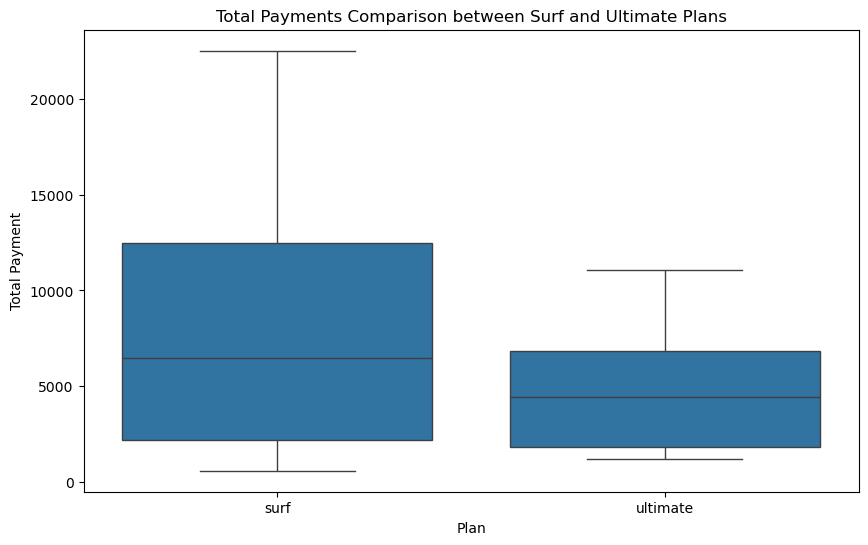

In [9]:
# Visualización de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='total_payment', data=grouped)
plt.title('Total Payments Comparison between Surf and Ultimate Plans')
plt.xlabel('Plan')
plt.ylabel('Total Payment')
plt.show()

### Conclusión

Con base en los resultados de las pruebas estadísticas y la visualización de los datos:

- Las pruebas de normalidad indican que los datos de ambos planes siguen una distribución normal.
- La prueba de Levene indica que las varianzas entre los grupos no son homogéneas.
- La prueba no paramétrica de Mann-Whitney U indica que no hay una diferencia significativa en los ingresos totales entre los usuarios de los planes "surf" y "ultimate".

Esto sugiere que, aunque las varianzas de los ingresos difieren entre los dos planes, las medianas de los ingresos no son significativamente diferentes. Los gráficos de cajas y bigotes confirman visualmente esta conclusión, mostrando la distribución de los ingresos para cada plan.

## Ny-NJ vs otros

Para llevar a cabo esta comparación, primero debemos verificar que los datos sean adecuados para una prueba estadística. Usaremos los ingresos totales (`total_payment`) de los usuarios en el área NY-NJ y los compararemos con los de otras regiones. Aquí está el proceso paso a paso:

### Paso 1: Preparación de los Datos

Filtraremos los datos para obtener dos conjuntos: uno para los usuarios del área NY-NJ y otro para los usuarios de otras regiones.

### Paso 2: Verificación de Suposiciones

- **Normalidad**: Usar pruebas de normalidad como Shapiro-Wilk.
- **Homogeneidad de Varianzas**: Usar la prueba de Levene.

### Paso 3: Selección de la Prueba Estadística

- **Prueba t de Student** para muestras independientes si se cumplen las suposiciones.
- **Prueba de Mann-Whitney U** si no se cumplen las suposiciones.

### Paso 4: Interpretación de los Resultados

Interpretar los resultados de la prueba estadística.

In [10]:
# Filtrar datos para NY-NJ y otras regiones
state_filter = (usage_data['state'].str.contains("NY") | usage_data['state'].str.contains("NJ"))

# Paso 2: Verificación de Suposiciones y Prueba Estadística
mht.AB_test(NY_NJ_payments:= usage_data[state_filter]["total_payment"].dropna(),
            other_payments:= usage_data[~state_filter]["total_payment"].dropna())

**Shapiro-Wilk Test para Grupo 1:**
- Estadístico: 0.665
- Valor p: 5.42e-14

**Shapiro-Wilk Test para Grupo 2:**
- Estadístico: 0.752
- Valor p: 2.54e-51


**Resultado de la prueba de homogeneidad de varianzas (Levene's Test):**
- Estadístico: 13.459
- Valor p: 2.49e-04


**Resultado de la prueba de hipótesis (Mann-Whitney U Test):**

- Estadístico: 73470.500

- Valor p: 2.38e-13

#### Interpretación de los Resultados:

- **Normalidad**: Ambas distribuciones de ingresos (NY-NJ y otras regiones) no siguen una distribución normal. Esto justifica el uso de la prueba no paramétrica de Mann-Whitney U en lugar de la prueba t de Student.
- **Homogeneidad de Varianzas**: La prueba de Levene mostró que las varianzas entre los dos grupos no son iguales, lo que refuerza la elección de una prueba no paramétrica.
- **Prueba de Mann-Whitney U**: El resultado de esta prueba indicó una diferencia significativa en los ingresos entre los usuarios de NY-NJ y los de otras regiones, con un p-value muy bajo (≈ 2.38e-13).

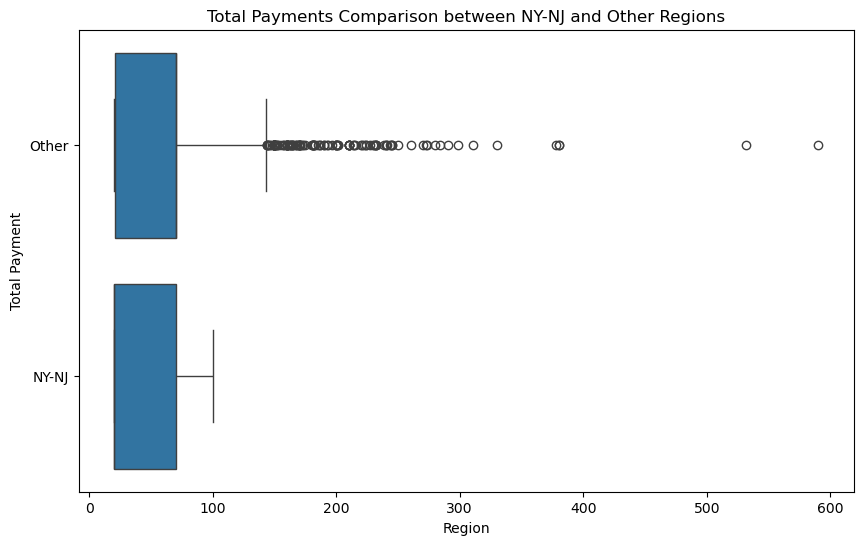

In [11]:
# Visualización de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(y=state_filter.replace({True: 'NY-NJ', False: 'Other'}),
            x='total_payment',
            data=usage_data)
plt.title('Total Payments Comparison between NY-NJ and Other Regions')
plt.xlabel('Region')
plt.ylabel('Total Payment')
plt.show()

Los resultados de las pruebas estadísticas y la visualización del gráfico de cajas proporcionarán una comprensión clara de si hay una diferencia significativa en los ingresos totales entre los usuarios del área NY-NJ y los usuarios de otras regiones.

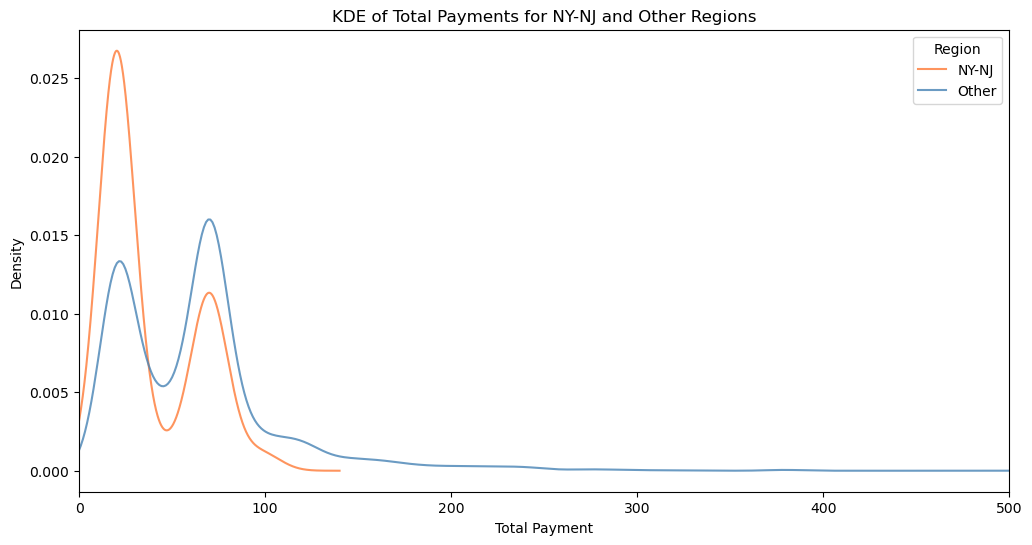

In [12]:
NY_NJ_payments.plot(kind='kde',
                figsize=(12, 6),
                xlim=(0, 500),
                color="#FE7A36",
                alpha=0.8
                )

other_payments.plot(kind='kde',
                color="steelblue",
                alpha=0.8)

plt.legend(['NY-NJ', 'Other'], title='Region')
plt.title('KDE of Total Payments for NY-NJ and Other Regions')
plt.xlabel('Total Payment')
plt.ylabel('Density')
plt.show()

In [13]:
# Filtrar datos para NY-NJ y otras regiones
state_filter = (usage_data['state'].str.contains("NY") | usage_data['state'].str.contains("NJ"))

# Paso 2: Verificación de Suposiciones y Prueba Estadística
mht.AB_test(NY_NJ_payments:= usage_data[state_filter]["total_payment"].dropna(),
            other_payments:= usage_data[~state_filter]["total_payment"].dropna())

**Shapiro-Wilk Test para Grupo 1:**
- Estadístico: 0.665
- Valor p: 5.42e-14

**Shapiro-Wilk Test para Grupo 2:**
- Estadístico: 0.752
- Valor p: 2.54e-51


**Resultado de la prueba de homogeneidad de varianzas (Levene's Test):**
- Estadístico: 13.459
- Valor p: 2.49e-04


**Resultado de la prueba de hipótesis (Mann-Whitney U Test):**

- Estadístico: 73470.500

- Valor p: 2.38e-13

La gráfica KDE mostrará la distribución de los ingresos totales (`total_payment`) para los usuarios del área NY-NJ y los usuarios de otras regiones. Esto proporciona una visualización adicional para comprender mejor las diferencias en las distribuciones de ingresos entre los dos grupos.

## Conclusion
Dado que los datos no son normales, las varianzas no son homogéneas y el resultado de la prueba de Mann-Whitney U muestra una diferencia significativa, podemos concluir que los ingresos totales de los usuarios de NY-NJ son significativamente diferentes de los ingresos totales de los usuarios de otras regiones.